In [1]:
import os
import sys
import traceback
from pathlib import Path as path

from dotenv import load_dotenv
from langgraph.graph import StateGraph
from langsmith import expect

from lib import cliBot, getAIMessage

working_dir = path().cwd().parent
sys.path.insert(0, str(working_dir))

In [2]:

from langchain_openai import ChatOpenAI

load_dotenv(override=True, dotenv_path=str(working_dir / "sample.env"))
llm_model = os.getenv("GPT_MODEL")
app_name = os.getenv("APP_NAME")

# llm_model, app_name
llm = ChatOpenAI(model=llm_model)

In [3]:
from langgraph.graph import MessagesState

class AgentState(MessagesState):
    pass

In [4]:
def agent(state: AgentState):
    return {"messages":[llm.invoke (state['messages'])]}

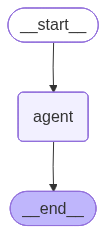

In [5]:
from langgraph.constants import END, START
from IPython.core.display import Image

g = StateGraph(AgentState)
# ADD NODES
g.add_node(agent)

# ADD EDGES
g.add_edge(START, "agent")
g.add_edge("agent", END)

gr = g.compile()

display(Image(gr.get_graph().draw_mermaid_png()))

In [6]:
try:
    cliBot(graphInstance= gr, show_all_msg=False)
except KeyboardInterrupt as ki:
    print("User choose to exit chat", file=sys.stderr)
except Exception as e:
    traceback.format_exc()

================================ Human Message =================================

sds
None
================================== Ai Message ==================================

It seems like you might have entered "sds" by mistake. How can I assist you today? If you have any questions or topics you'd like to discuss, feel free to let me know!
None


User choose to exit chat


In [12]:
from langchain_core.messages import HumanMessage


#stream Data
def stream_cli_bot(gi: StateGraph, config: str | None = None):
    exit_phrases = ["exit", "bye", "tata"]
    flag = True
    while flag:
        inputMsg = input("Please enter your message: ")
        if inputMsg.strip().lower() in exit_phrases:
            flag = False
            print("Human requested to close session!!! Bye see you around")
        else:
            strippedMsg = inputMsg.strip()
            humanMessage = [HumanMessage(content=strippedMsg)]
            if config is None:
                streamed_response = gi.stream({"messages": humanMessage}, stream_mode = "update")
            else:
                streamed_response = gi.stream({"messages": humanMessage}, config, stream_mode = "update")

        for msg  in streamed_response:
            msg['conversation']["messages"].pretty_print()


In [35]:
# Start conversation
for chunk in gr.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, stream_mode="updates"):
 for m in chunk["agent"]["messages"]:
        m.pretty_print()

================================== Ai Message ==================================

Hi Lance! How can I assist you today?


In [19]:
from lib import getAIMessage
res = gr.invoke({"messages": [HumanMessage(content="hi! I'm Lance")]})
getAIMessage(res)

'Hi Lance! How can I assist you today?'